# Spooky Author - Feature Extraction for Topic Modelling and Visualizations



**I will be doing features engineering and try to generate all possible kind of features**


 
| S. no.                 | Feature type                                                                                                   |                Status                            |
|:---------------------:|:---------------------------------------------------------------------------------------------------:|:-------------------------------------------:|
| 1                         | Author characteristic writing style based features              | Completed                     |
| 2 | Text -word- based pred features - predictions of Multinonial Naive Bayes on word based tf-idf| Completed |
| 3 | Text -character -based features - prediction of Multinonial Naive Bayes on based tf-idf | Completed |
| 4 | Text -word_based features - predictions of Multinonial Naive Bayes on word counts vector | In Progress |
| 5 | Text -character-based features - prediction of Multinonial Naive Bayes on character counts vector | In Proress |
| 6 | SVD comp on word based tf_idf | Completed |
| 7 | SVD comp on character based tf_idf | Due |
| 8 | **Markov event based features - P(*author/sentence*) for all Authors **| ***New***|
| 9 | Sentiment Analysis based features - flagging sentence as having surprize, fear, jovial feelings | To be started  |
| 10 | word embedings based features - sentence to vector using conventional approach  | To be started ||




# Preamble 
In this challange, data science community is challenged to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. This kernel will be my attempt on topic modelling and creating a multiclass classifier. I will be covering different feature extraction techniques- handcrafted and using tf-idf etc, will be explaining the nadir of topic modelling- LDA, and NNMF. Further Topic I will add as we go ahead and analysis the data. So, Lets dive in ..


In [28]:
# Importing the libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import time
import spacy
from scipy.misc import imread


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pcorr/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [5]:
start_time = time.time()
train_df = pd.read_csv("../Data/train.csv")
test_df = pd.read_csv("../Data/test.csv")
end = time.time()
print("Time taken in reading the input files is {}.".format(end - start_time))
train_df.head()

Time taken in reading the input files is 0.06634807586669922.


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


We are given the minimum number of fields here - 
- **id** -  Id of the record 
- **text** - Text - main input data 
- **author** - Author of the given text
In train data the author is given for each text for training, and in text we are only given text data and we are expected to predict the author using the given text. **

In [6]:
# Explore the dataset 
print("Number of rows in train dataset {} ".format(train_df.shape[0]))
print("Number of rows in test dataset {} ".format(test_df.shape[0]))
print("No duplicates in train data") if train_df.shape[0] == train_df.text.unique().__len__() else print("Oops")
print("No duplicates in test data") if test_df.shape[0] == test_df.text.unique().__len__() else print("Oops")
print("Unique author is data {}.".format(train_df.author.unique()))
print("Number of nulls in the train is {} and text is {}.".format(train_df.isnull().sum().sum(), test_df.isnull().sum().sum()))

Number of rows in train dataset 19579 
Number of rows in test dataset 8392 
No duplicates in train data
No duplicates in test data
Unique author is data ['EAP' 'HPL' 'MWS'].
Number of nulls in the train is 0 and text is 0.


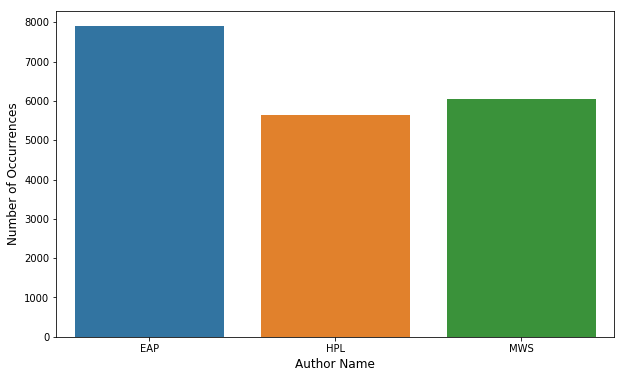

In [7]:
# Checking the frequencies of text for all author in training dataset
author_summary = pd.DataFrame(train_df.groupby('author')['text'].count())
author_summary.reset_index(inplace = True)
plt.figure(figsize=(10,6))
sns.barplot(author_summary.author, author_summary.text)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [8]:
# Lets check the avg number of words in text written by each author in a histogram 
def word_count(row):
    """function to calculate the count of words in a given text """
    text = row['text']
    text_splited = text.split(' ')
    word_count = text_splited.__len__()
    return word_count

train_df['word_count'] = ''
train_df['word_count'] = train_df.apply(lambda row: word_count(row), axis =1)
test_df['word_count'] = test_df.apply(lambda row: word_count(row), axis =1)

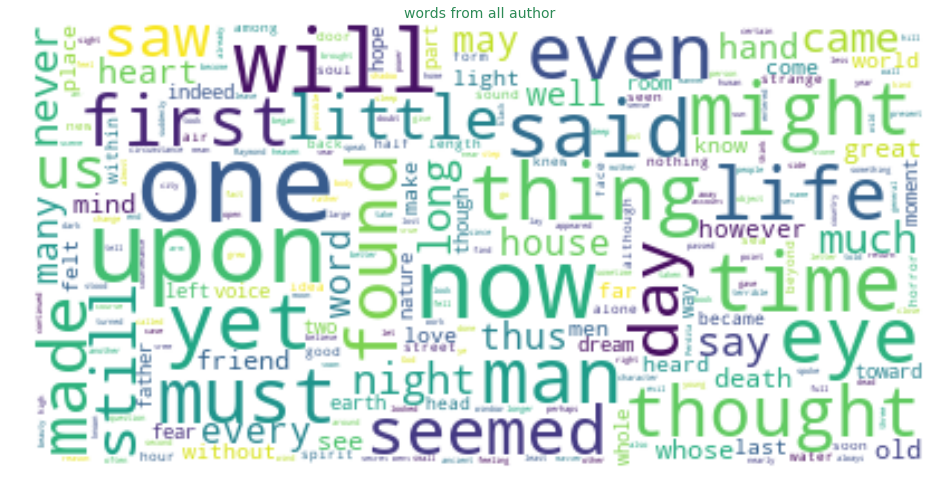

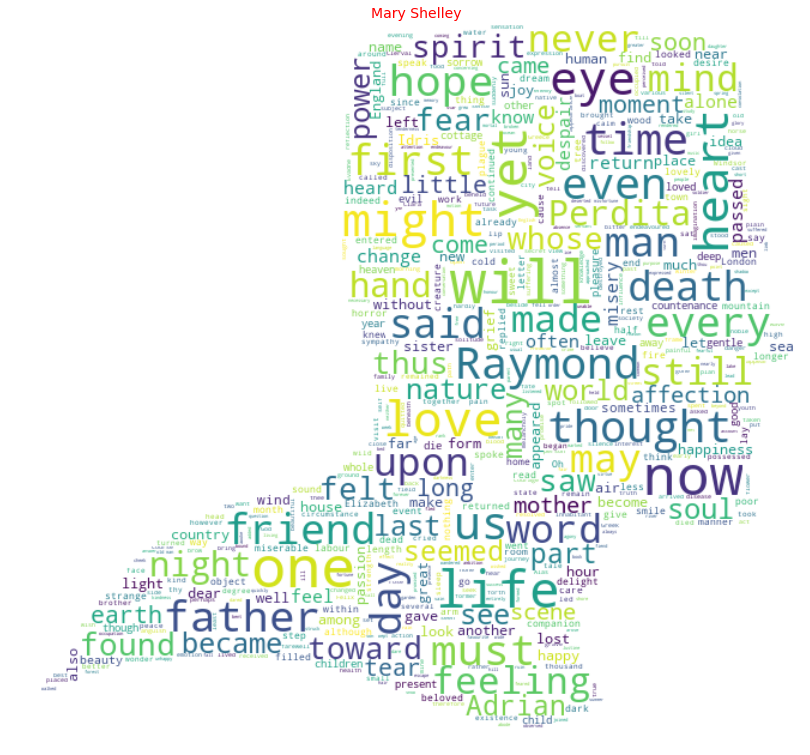

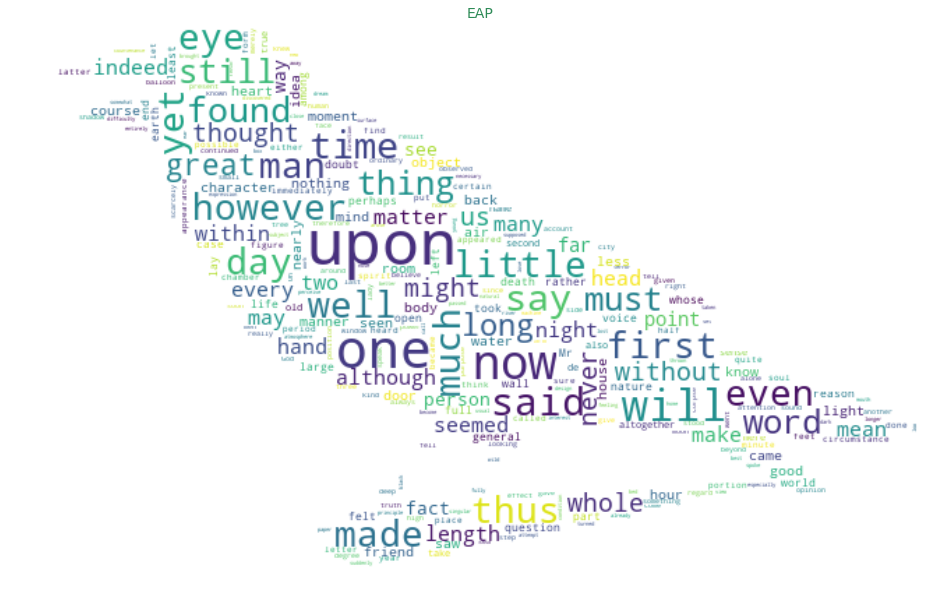

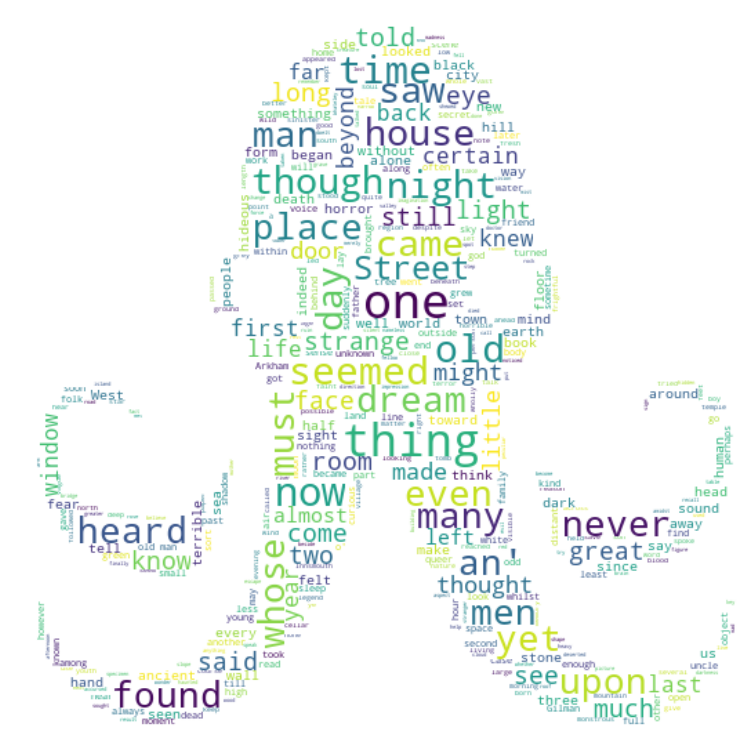

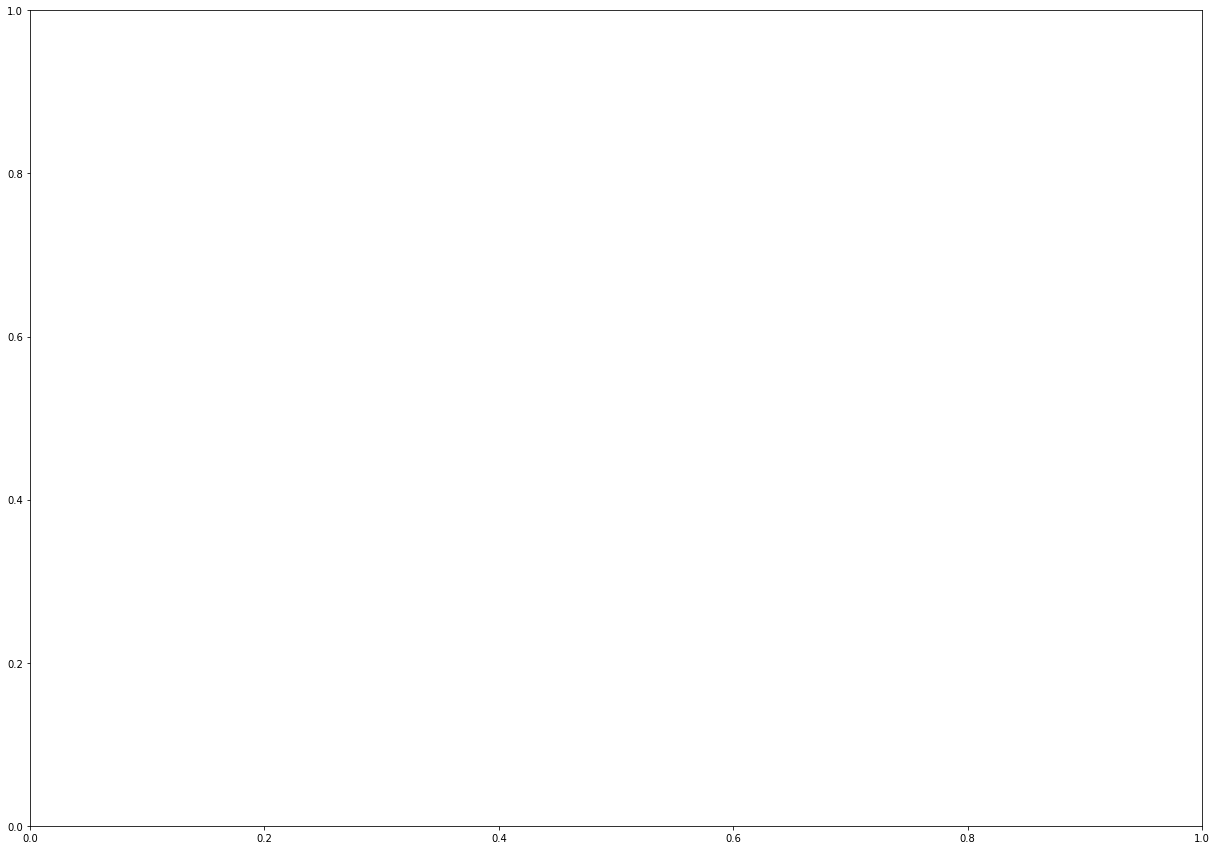

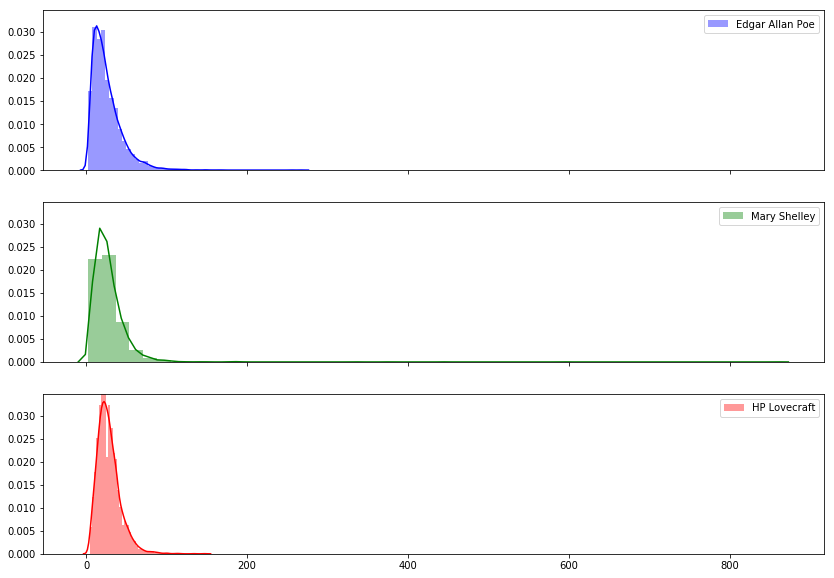

Time taken by above cell is 3.270888090133667.


In [23]:
start = time.time()
fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(14,10))
sns.distplot(train_df.loc[train_df['author']=='EAP']['word_count'].values, ax=ax[0], color='blue', label='Edgar Allan Poe')
sns.distplot(train_df.loc[train_df['author']=='MWS']['word_count'].values, ax=ax[1], color='green', label='Mary Shelley')
sns.distplot(train_df.loc[train_df['author']=='HPL']['word_count'].values, ax=ax[2], color='red', label='HP Lovecraft')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
ax[2].legend(loc=0)
plt.show()
end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

**Findings** - It can be clearly seen that most of the texts given in the training dataset are has word count from 0 to ~100, but the distribution is diferent in right portion of histograms.  HP lovecrafts's text are less scattered, followed by EAP's, and Mary Sheley's text few texts has length ~900 too. This information can be used in hand designed features, for example we can make feature of 0/1 if text is greater than 250 or not, or we can make bins and use this feature, this will sure help in classification of Mary Shelley.

# Fun time over, Now, I will seriously focus on feature engineering..
Here we can go ahead with finding features based on the text like have the frequency data each of the word and then apply NB ( like they do in spam and ham classification) or extract features that may be the characteristics of different author and then using those features along with the text releted features and train some classifier on it.

## Features corresponding to characteristics of different author's writting style
Here my assuption is that each text that's been given is a paragraph in one of the books of corresponding author. Based on that assumption if we try and we can see if there is any pattern in author's writting style and based on that we can classify which text belong to which author. As of now, I am thinking about following features that can be put in this category. they are - 
- word_count - The count of words in given text 
- unique_words_fraction - Fraction of words that are unique in a given text 
- stop_words - Fraction of stopwords present in a given text - Number of stopwords/Total words
- punctuations - Fraction of punctuation present in a given text - Number of puctuations/Total words
- fract_Nouns - Fraction of Nuons
- fract_adj - Fraction of Adjectives present in a text 

As of now I can think of these aforesaid features, will update this list of features if I extract any other features than mentioned features. Lets define function for features releted to author's characteristics and then run those function for final feature extraction.

**Note** - Here for some or most of the features I have used fraction and not the number as my person experience of document classification using manualluy designed features says that it make more sense to use fraction as if one text is larger thgan the author the number will mislead you while fraction will cover the pith about author's characteristics.



In [24]:
train_df.head()

,id,text,author,word_count
0,id26305,"This process, however, afforded me no means of...",EAP,41
1,id17569,It never once occurred to me that the fumbling...,HPL,14
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [25]:
import string
def unique_word_fraction(row):
    """function to calculate the fraction of unique words on total words of the text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    unique_count = list(set(text_splited)).__len__()
    return (unique_count/word_count)


eng_stopwords = set(stopwords.words("english"))
def stopwords_count(row):
    """ Number of stopwords fraction in a text"""
    text = row['text'].lower()
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    stopwords_count = len([w for w in text_splited if w in eng_stopwords])
    return (stopwords_count/word_count)


def punctuations_fraction(row):
    """functiopn to claculate the fraction of punctuations over total number of characters for a given text """
    text = row['text']
    char_count = len(text)
    punctuation_count = len([c for c in text if c in string.punctuation])
    return (punctuation_count/char_count)


def char_count(row):
    """function to return number of chracters """
    return len(row['text'])

def fraction_noun(row):
    """function to give us fraction of noun over total words """
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    noun_count = len([w for w in pos_list if w[1] in ('NN','NNP','NNPS','NNS')])
    return (noun_count/word_count)

def fraction_adj(row):
    """function to give us fraction of adjectives over total words in given text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    adj_count = len([w for w in pos_list if w[1] in ('JJ','JJR','JJS')])
    return (adj_count/word_count)

def fraction_verbs(row):
    """function to give us fraction of verbs over total words in given text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    word_count = text_splited.__len__()
    pos_list = nltk.pos_tag(text_splited)
    verbs_count = len([w for w in pos_list if w[1] in ('VB','VBD','VBG','VBN','VBP','VBZ')])
    return (verbs_count/word_count)



# Features extraction
### Applying functions-defined above-to extract features based on characteristics of author's writing style...

In [30]:
train_df['unique_word_fraction'] = train_df.apply(lambda row: unique_word_fraction(row), axis =1)
train_df['stopwords_count'] = train_df.apply(lambda row: stopwords_count(row), axis =1)
train_df['punctuations_fraction'] = train_df.apply(lambda row: punctuations_fraction(row), axis =1)
train_df['char_count'] = train_df.apply(lambda row: char_count(row), axis =1)
train_df['fraction_noun'] = train_df.apply(lambda row: fraction_noun(row), axis =1)
train_df['fraction_adj'] = train_df.apply(lambda row: fraction_adj(row), axis =1)
train_df['fraction_verbs'] = train_df.apply(lambda row: fraction_verbs(row), axis =1)
train_df.head()

,id,text,author,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs
0,id26305,"This process, however, afforded me no means of...",EAP,41,0.853659,0.487805,0.030303,231,0.243902,0.048780,0.146341
1,id17569,It never once occurred to me that the fumbling...,HPL,14,1.000000,0.571429,0.014085,71,0.142857,0.071429,0.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,0.888889,0.472222,0.025000,200,0.277778,0.138889,0.111111
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,0.941176,0.382353,0.019417,206,0.294118,0.176471,0.147059
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,0.925926,0.407407,0.022989,174,0.222222,0.037037,0.222222


In [31]:
test_df['unique_word_fraction'] = test_df.apply(lambda row: unique_word_fraction(row), axis =1)
test_df['stopwords_count'] = test_df.apply(lambda row: stopwords_count(row), axis =1)
test_df['punctuations_fraction'] = test_df.apply(lambda row: punctuations_fraction(row), axis =1)
test_df['char_count'] = test_df.apply(lambda row: char_count(row), axis =1)
test_df['fraction_noun'] = test_df.apply(lambda row: fraction_noun(row), axis =1)
test_df['fraction_adj'] = test_df.apply(lambda row: fraction_adj(row), axis =1)
test_df['fraction_verbs'] = test_df.apply(lambda row: fraction_verbs(row), axis =1)
test_df.head()

,id,text,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,fraction_verbs
0,id02310,"Still, as I urged our leaving Ireland with suc...",19,1.000000,0.473684,0.027273,110,0.210526,0.105263,0.210526
1,id24541,"If a fire wanted fanning, it could readily be ...",62,0.790323,0.548387,0.021212,330,0.258065,0.032258,0.161290
2,id00134,And when they had broken down the frail door t...,33,0.909091,0.484848,0.015873,189,0.212121,0.121212,0.151515
3,id27757,While I was thinking how I should possibly man...,41,0.829268,0.512195,0.022422,223,0.170732,0.048780,0.170732
4,id04081,I am not sure to what limit his knowledge may ...,11,1.000000,0.545455,0.018868,53,0.090909,0.090909,0.272727


# Features (characteristics of author's writing style) visualization 
When we extract these features we know already that these features doen't have very large predictive power (by experience), but can help in some cases, so, Lets examine how these features are behaving for this problem. We will use boxplot and voilinplots for visualizing these features. 

In [32]:
f, axes = plt.subplots(3,2,figsize=(21, 18), sharex=True, sharey = False)
sns.despine(left=True)
sns.set_context("poster")
sns.violinplot(x="author", y="unique_word_fraction", data=train_df, ax = axes[0,0])
sns.violinplot(x="author", y="stopwords_count", data=train_df, ax = axes[0,1])
sns.violinplot(x="author", y="punctuations_fraction", data=train_df, ax = axes[1,0])
sns.violinplot(x="author", y="fraction_verbs", data=train_df, ax = axes[1,1])
sns.violinplot(x="author", y="fraction_noun", data=train_df, ax = axes[2,0])
sns.violinplot(x="author", y="fraction_adj", data=train_df, ax = axes[2,1])
sns.despine(left=True)

**Findings -** 
- **Stopwords**
 - All the authors are have similar pattern for stopwords, but HPL is using slightly less number of stopwords per text. Somewhat useful
- **Punctuation_fraction**
 - See the grapth of punctuationfraction is very smooth here, for all the three authors. This is very useful as you can just classify cases sometimes based on this functions value. for example a decision tree can use this feature for spliting and claerly assign EAP if the value of punctuation fraction is greater than 0.3. so this feature will sure help in tree split in XGB.
 - Secondly, I haven't reproduced it here but if you see the plot of number of punctuations in here-  (http://)https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author in SRK's notebook, you will see that its not smooth. So, normalization here will sure play a part in final outcome.
 - Most of the text have similar mean and have similar quartile ranges, so, this doesn't contain very high prediction power but it will sure help classifying some cases.
- **Other Features**
 - **Unique_words** - HPL is using more unique words than the other two.
 - **Noun,verbs, adj** - HPL is using slightly more number of nouns than other two.
 

In [33]:
# word_count and char_counts
f, axes = plt.subplots(nrows=1, ncols=2,figsize=(24, 11), sharex=True, sharey = False)
sns.set(style="ticks")
sns.set_context("poster")
sns.boxplot(y="word_count", x="author", data=train_df, palette="PRGn", ax = axes[0])
sns.boxplot(y="char_count", x="author", data=train_df, palette="PRGn", ax = axes[1])
sns.despine(offset=10, trim=True)

# Extracting sentiments in sentences 
I will use four different kinds of sentiments and using the most frequently occurring words to that sentiment, will given if that particular sentiment is present or not. The four different kinds of sentiments are as follows - 
- Surprize - 1/0 if it contains surprize words
- Fear -1/0 using fear words
- Joy - 1/0 using jovial words



In [34]:
Surprize_words = ['finally', 'suddenly', 'mystery', 'fortune', 'sweet', 'horror', 'chance', '']

# Extracting Features related to text
## Tf-idf features 

In [35]:
start = time.time()
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())
end = time.time()
print("Time taken in tf-idf is {}.".format(end-start))

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)

Time taken in tf-idf is 4.399755954742432.


In [36]:
# this function is taken from SRK's notebook
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.842216198361


In [37]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.450918416166


In [38]:
start = time.time()
n_comp = 400
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd
end = time.time()
print("Time taken in tf-idf is {}.".format(end-start))

Time taken in tf-idf is 59.86591625213623.


In [39]:
#character based tfidf
start = time.time()
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())
n_comp = 40
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))   
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd
end = time.time()
print("Time taken in tf-idf is {}.".format(end-start))

Time taken in tf-idf is 34.775826930999756.


# Markov Model based features 

In [40]:
val_df = train_df.sample(frac=0.2, replace=False)
trn_df = train_df.drop(val_df.index)
print(trn_df.shape[0])
print(val_df.shape[0])
print(train_df.shape[0])
trn_df.head()

15663
3916
19579


,id,text,author,word_count,unique_word_fraction,stopwords_count,punctuations_fraction,char_count,fraction_noun,fraction_adj,...,svd_char_30,svd_char_31,svd_char_32,svd_char_33,svd_char_34,svd_char_35,svd_char_36,svd_char_37,svd_char_38,svd_char_39
0,id26305,"This process, however, afforded me no means of...",EAP,41,0.853659,0.487805,0.030303,231,0.243902,0.048780,...,0.009868,0.024277,0.008466,-0.024082,-0.035531,-0.005016,-0.038036,0.038413,0.041847,0.003943
1,id17569,It never once occurred to me that the fumbling...,HPL,14,1.000000,0.571429,0.014085,71,0.142857,0.071429,...,-0.002132,-0.059521,-0.041676,-0.009070,0.024876,0.041630,-0.053223,0.025573,0.041461,0.085484
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,0.888889,0.472222,0.025000,200,0.277778,0.138889,...,-0.009112,0.003816,0.015761,0.013422,0.004711,0.014774,0.013029,-0.039625,0.015251,-0.043975
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,0.941176,0.382353,0.019417,206,0.294118,0.176471,...,0.010779,0.003317,0.000928,-0.008916,0.024795,0.043941,-0.023073,-0.000417,-0.007978,0.001714
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,0.925926,0.407407,0.022989,174,0.222222,0.037037,...,0.027210,-0.018127,0.054508,0.029705,0.021277,0.013566,0.009387,0.008615,-0.044040,0.002825


In [41]:
import random

class Dictogram(dict):
    def __init__(self, iterable=None):
        """Initialize this histogram as a new dict; update with given items"""
        super(Dictogram, self).__init__()
        self.types = 0  # the number of distinct item types in this histogram
        self.tokens = 0  # the total count of all item tokens in this histogram
        if iterable:
            self.update(iterable)

    def update(self, iterable):
        """Update this histogram with the items in the given iterable"""
        for item in iterable:
            if item in self:
                self[item] += 1
                self.tokens += 1
            else:
                self[item] = 1
                self.types += 1
                self.tokens += 1

    def count(self, item):
        """Return the count of the given item in this histogram, or 0"""
        if item in self:
            return self[item]
        return 0

    def return_random_word(self):
        # Another way:  Should test: random.choice(histogram.keys())
        random_key = random.sample(self, 1)
        return random_key[0]

    def return_weighted_random_word(self):
        # Step 1: Generate random number between 0 and total count - 1
        random_int = random.randint(0, self.tokens-1)
        index = 0
        list_of_keys = self.keys()
        # print 'the random index is:', random_int
        for i in range(0, self.types):
            index += self[list_of_keys[i]]
            # print index
            if(index > random_int):
                # print list_of_keys[i]
                return list_of_keys[i]

In [42]:
# markov chain based features, 3 words memory 
def make_higher_order_markov_model(order, data):
    markov_model = dict()

    for i in range(0, len(data)-order):
        # Create the window
        window = tuple(data[i: i+order])
        # Add to the dictionary
        if window in markov_model:
            # We have to just append to the existing Dictogram
            markov_model[window].update([data[i+order]])
        else:
            markov_model[window] = Dictogram([data[i+order]])
    return markov_model

In [43]:
print(trn_df.loc[train_df['author']=='EAP'].shape[0])
def tokenixed_list(row):
    """function to calculate the fraction of unique words on total words of the text"""
    text = row['text']
    text_splited = text.split(' ')
    text_splited = [''.join(c for c in s if c not in string.punctuation) for s in text_splited]
    text_splited = [s for s in text_splited if s]
    return (text_splited)
trn_df['splited_text'] = trn_df.apply(lambda row: tokenixed_list(row), axis =1)

6300


In [44]:
eap = trn_df.loc[trn_df['author']=='EAP']['splited_text'].values
flat_eap = []
eap_flat = [flat_eap.extend(x) for x in eap]
flat_eap.__len__()
eap_MM = make_higher_order_markov_model(3, flat_eap)

In [45]:
hpl = trn_df.loc[trn_df['author']=='HPL']['splited_text'].values
flat_hpl = []
hpl_flat = [flat_hpl.extend(x) for x in hpl]
flat_hpl.__len__()
hpl_MM = make_higher_order_markov_model(3, flat_hpl)

In [46]:
ms = trn_df.loc[trn_df['author']=='MWS']['splited_text'].values
flat_ms = []
ms_flat = [flat_ms.extend(x) for x in ms]
flat_ms.__len__()
ms_MM = make_higher_order_markov_model(3, flat_ms)

In [47]:
#probablity calculation using markov chain
#print(eap_MM[('no', 'means', 'of')])
#print(sum([x for x in eap_MM[('no', 'means', 'of')].values()]))
def spit_out_prob(tupl , word , mm1= eap_MM, mm2 = hpl_MM, mm3 = ms_MM):
    """function to spit out a prob of a word given a tuple and a word and a markov model"""
    """fix this function, its working but not calculating probabilities, but providing
    some confidance index, greater than confidance index is, larger is the prob"""
    try:
        a = mm1[tupl][word]
    except:
        a = 0 
    try:
        b = mm2[tupl][word]
    except:
        b = 0
    try:
        c = mm3[tupl][word]
    except:
        c = 0
    try:
        prob_word = a/(a+b+c)#(sum([x for x in mm[tupl].values()]))
        return (prob_word)
    except:
        return (0) #earlier it was 1



def make_tupl(sentence =trn_df.loc[train_df['author']=='EAP']['splited_text'][0] , n=3):
    """function to make tuples of n size given a sentence and n"""
    list_of_tuple = []
    word_1 = []
    for i in list(range(sentence.__len__()-3)):
        tuple_1 = (sentence[i], sentence[i+1], sentence[i+2])
        list_of_tuple.append(tuple_1)
        word_1.append(sentence[i+3])
    return (list_of_tuple, word_1)


def sent_to_prob_eap(sentence, mm1 = eap_MM, p_eap =1/3, mm2 = hpl_MM, mm3 = ms_MM):
    """function to get the markov model to give prob of a author given a sentence """
    list_of_tuples = make_tupl(sentence, n =3)[0]
    words = make_tupl(sentence, n =3)[1]
    #print(list_of_tuples, words)
    #p = p_eap 
    p=0
    for i in list(range(words.__len__())):
        #print(list_of_tuples[i], words[i])
        p = p+spit_out_prob(list_of_tuples[i], words[i], mm1 =eap_MM, mm2 =hpl_MM, mm3 =ms_MM)
    return(p)

def sent_to_prob_hpl(sentence, mm2 = hpl_MM, p_hpl =1/3, mm1 = eap_MM, mm3 = ms_MM):
    """function to get the markov model to give prob of a author given a sentence """
    list_of_tuples = make_tupl(sentence, n =3)[0]
    words = make_tupl(sentence, n =3)[1]
    #print(list_of_tuples, words)
    #p = p_hpl 
    p = 0
    for i in list(range(words.__len__())):
        #print(list_of_tuples[i], words[i])
        p = p+spit_out_prob(list_of_tuples[i], words[i], mm1 =hpl_MM, mm2=eap_MM, mm3=ms_MM)
    return(p)

def sent_to_prob_ms(sentence, mm3 = ms_MM, p_ms =1/3, mm2 = hpl_MM, mm1 = eap_MM):
    """function to get the markov model to give prob of a author given a sentence """
    list_of_tuples = make_tupl(sentence, n =3)[0]
    words = make_tupl(sentence, n =3)[1]
    #print(list_of_tuples, words)
    #p = p_ms 
    p = 0
    for i in list(range(words.__len__())):
        #print(list_of_tuples[i], words[i])
        p = p+spit_out_prob(list_of_tuples[i], words[i], ms_MM, hpl_MM, eap_MM)
    return(p)



In [48]:
# calculating markov chain based features
trn_df['EAP_markov_3'] = trn_df['splited_text'].apply(lambda row: sent_to_prob_eap(sentence =row))
trn_df['HPL_markov_3'] = trn_df['splited_text'].apply(lambda row: sent_to_prob_hpl(sentence = row))
trn_df['MWS_markov_3'] = trn_df['splited_text'].apply(lambda row: sent_to_prob_ms(sentence = row))
trn_df[['MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3', 'author']].head()
del trn_df['splited_text']

In [49]:
val_df['splited_text'] = val_df.apply(lambda row: tokenixed_list(row), axis =1)
val_df['EAP_markov_3'] = val_df['splited_text'].apply(lambda row: sent_to_prob_eap(sentence =row))
val_df['HPL_markov_3'] = val_df['splited_text'].apply(lambda row: sent_to_prob_hpl(sentence = row))
val_df['MWS_markov_3'] = val_df['splited_text'].apply(lambda row: sent_to_prob_ms(sentence = row))
val_df1 = val_df[['MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3','author']].copy()
del val_df['splited_text']

In [50]:
test_df['splited_text'] = test_df.apply(lambda row: tokenixed_list(row), axis =1)
test_df['EAP_markov_3'] = test_df['splited_text'].apply(lambda row: sent_to_prob_eap(sentence =row))
test_df['HPL_markov_3'] = test_df['splited_text'].apply(lambda row: sent_to_prob_hpl(sentence = row))
test_df['MWS_markov_3'] = test_df['splited_text'].apply(lambda row: sent_to_prob_ms(sentence = row))
test_df1 = test_df[['MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3']].copy()
del test_df['splited_text']

# XGB Model

In [51]:
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
trn_y = trn_df['author'].map(author_mapping_dict)
val_y = val_df['author'].map(author_mapping_dict)
cols_drop = ['id', 'text','MWS_markov_3', 'EAP_markov_3', 'HPL_markov_3']
trn_X = trn_df.drop(cols_drop+['author'], axis=1)
val_X = val_df.drop(cols_drop+['author'], axis=1)
test_X = test_df.drop(cols_drop, axis=1)

In [52]:
print(52*'-')
print("shape of train val is {} and {}, test is {}".format(trn_X.shape[1], val_X.shape[1], test_X.shape[1]))
print(52*'-')

----------------------------------------------------
shape of train val is 451 and 451, test is 451
----------------------------------------------------


In [53]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
Xtr = trn_X.values
Xv = val_X.values
ytr = trn_y
yv = val_y
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test_X.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

start = time.time()
xgb_par = {'min_child_weight': 1, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 3,
            'subsample': 0.8, 'lambda': 2.0, 'nthread': -1, 'silent': 1,
            'eval_metric': "mlogloss", 'objective': 'multi:softprob', 'num_class': 3}

model_1 = xgb.train(xgb_par, dtrain, 1000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=40)
print('Modeling RMSLE %.5f' % model_1.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))

/Users/pcorr/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0]	train-mlogloss:1.01992	valid-mlogloss:1.02054
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 50 rounds.
[40]	train-mlogloss:0.387626	valid-mlogloss:0.404054
[80]	train-mlogloss:0.339007	valid-mlogloss:0.378895
[120]	train-mlogloss:0.306214	valid-mlogloss:0.37074
[160]	train-mlogloss:0.280495	valid-mlogloss:0.365928
[200]	train-mlogloss:0.258154	valid-mlogloss:0.363484
[240]	train-mlogloss:0.238359	valid-mlogloss:0.362295
[280]	train-mlogloss:0.220759	valid-mlogloss:0.36195
[320]	train-mlogloss:0.205011	valid-mlogloss:0.360661
[360]	train-mlogloss:0.190999	valid-mlogloss:0.360948
Stopping. Best iteration:
[337]	train-mlogloss:0.199027	valid-mlogloss:0.360411

Modeling RMSLE 0.36041
Time taken in training is 168.6351249217987.


In [54]:
print(test_X.shape, trn_X.shape)

(8392, 451) (15663, 451)


In [55]:

start = time.time()
yvalid = model_1.predict(dvalid)
ytest = model_1.predict(dtest)
end = time.time()
print("Time taken in prediction is {}.".format(end - start))

Time taken in prediction is 0.3355538845062256.


In [56]:
val_df1.head()
val_df2 = pd.DataFrame(yvalid)
val_df2.head()
val_df2.columns = ['EAP', 'HPL', 'MWS']
val_df2.head()
val_df1.reset_index(inplace = True, drop =True)
val_df1.head()


,MWS_markov_3,EAP_markov_3,HPL_markov_3,author
0,1.5,0.166667,2.333333,HPL
1,0.5,1.000000,0.500000,MWS
2,0.0,0.000000,0.000000,MWS
3,0.0,0.000000,0.000000,MWS
4,0.0,0.000000,0.000000,MWS


In [57]:
val = pd.concat([val_df1, val_df2], axis =1)
val.head()

,MWS_markov_3,EAP_markov_3,HPL_markov_3,author,EAP,HPL,MWS
0,1.5,0.166667,2.333333,HPL,0.003067,0.977812,0.019121
1,0.5,1.000000,0.500000,MWS,0.084167,0.094980,0.820853
2,0.0,0.000000,0.000000,MWS,0.001721,0.000666,0.997613
3,0.0,0.000000,0.000000,MWS,0.160558,0.216880,0.622563
4,0.0,0.000000,0.000000,MWS,0.009631,0.000833,0.989535


In [58]:
start = time.time()
if test_df.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test_id = test_df['id'].values
out_df = pd.DataFrame(ytest)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("Mahesh_xgb_test.csv", index=False)
end = time.time()
print("Time taken in training is {}.".format(end - start))

Test shape OK.
Time taken in training is 0.04955792427062988.


In [59]:
## Let's submit and see where we stand on LB 
out_df.head()
test_df2 = out_df[['EAP','HPL', 'MWS']]
test_df2.head()
test_df1.head()
t = pd.concat([test_df1, test_df2], axis =1)
t.head()

,MWS_markov_3,EAP_markov_3,HPL_markov_3,EAP,HPL,MWS
0,0.0,1.0,0.0,0.044903,0.013479,0.941618
1,1.5,3.0,0.5,0.998841,0.000517,0.000642
2,0.0,0.0,0.0,0.104645,0.893205,0.002150
3,0.0,3.0,1.0,0.793909,0.193020,0.013071
4,0.0,1.0,0.0,0.901713,0.073905,0.024382


In [60]:
# linear combination 
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
trn_y = val['author'].map(author_mapping_dict)
import xgboost as xgb
from sklearn.model_selection import train_test_split
Xtr = val[['MWS_markov_3','EAP_markov_3','HPL_markov_3','EAP','HPL','MWS']].values
ytr = trn_y
dtrain = xgb.DMatrix(Xtr, label=ytr)
#dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(t.values)
watchlist = [(dtrain, 'train')]

start = time.time()
xgb_par = {'min_child_weight': 1, 'eta': 0.1, 'colsample_bytree': 0.7, 'max_depth': 3,
            'subsample': 0.8, 'lambda': 2.0, 'nthread': -1, 'silent': 1,
            'eval_metric': "mlogloss", 'objective': 'multi:softprob', 'num_class': 3}

model_2 = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50, maximize=False, verbose_eval=100)
print('Modeling RMSLE %.5f' % model_2.best_score)
end = time.time()
print("Time taken in training is {}.".format(end - start))

[0]	train-mlogloss:0.998325
Will train until train-mlogloss hasn't improved in 50 rounds.
[100]	train-mlogloss:0.302588
[200]	train-mlogloss:0.263018
[300]	train-mlogloss:0.235425
[400]	train-mlogloss:0.211279
[500]	train-mlogloss:0.192901
[600]	train-mlogloss:0.176131
[700]	train-mlogloss:0.162415
[800]	train-mlogloss:0.149364
[900]	train-mlogloss:0.138879
[1000]	train-mlogloss:0.128774
[1100]	train-mlogloss:0.119895
[1200]	train-mlogloss:0.111721
[1300]	train-mlogloss:0.104382
[1400]	train-mlogloss:0.097591
[1500]	train-mlogloss:0.091192
[1600]	train-mlogloss:0.085599
[1700]	train-mlogloss:0.080385
[1800]	train-mlogloss:0.075736
[1900]	train-mlogloss:0.071317
Modeling RMSLE 0.06722
Time taken in training is 5.42178201675415.


In [61]:
start = time.time()
ytest = model_2.predict(dtest)
end = time.time()
print("Time taken in prediction is {}.".format(end - start))

Time taken in prediction is 1.7182917594909668.


In [62]:
start = time.time()
if test_df.shape[0] == ytest.shape[0]:
    print('Test shape OK.') 
test_id = test_df['id'].values
out_df = pd.DataFrame(ytest)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("Mahesh_xgb_test_lc.csv", index=False)
end = time.time()
print("Time taken in training is {}.".format(end - start))

Test shape OK.
Time taken in training is 0.04403400421142578.


In [63]:
out_df.head()

,id,EAP,HPL,MWS
0,id02310,0.020868,0.001286,0.977846
1,id24541,0.999464,0.000311,0.000225
2,id00134,0.032166,0.967338,0.000495
3,id27757,0.997486,0.001252,0.001262
4,id04081,0.972237,0.026245,0.001518


**Upvote if you found this kernel useful ..Thanks **

In [64]:
# Save Results

In [67]:
out_df.to_csv('../predictions/xgboost_pred.csv', index=False)